In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
df = pd.read_csv('Train_Data.csv')
df.sample(5)

,SEQN,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
558,76514.0,26.0,2.0,2.0,20.4,90.0,2.0,49.0,3.19,Adult
1441,81060.0,14.0,2.0,2.0,22.5,96.0,2.0,107.0,7.62,NaN
1581,81748.0,22.0,1.0,2.0,22.9,87.0,2.0,131.0,5.63,Adult
179,74498.0,29.0,1.0,2.0,33.2,96.0,2.0,99.0,17.23,Adult
1731,82487.0,21.0,1.0,2.0,20.8,99.0,2.0,73.0,8.43,Adult


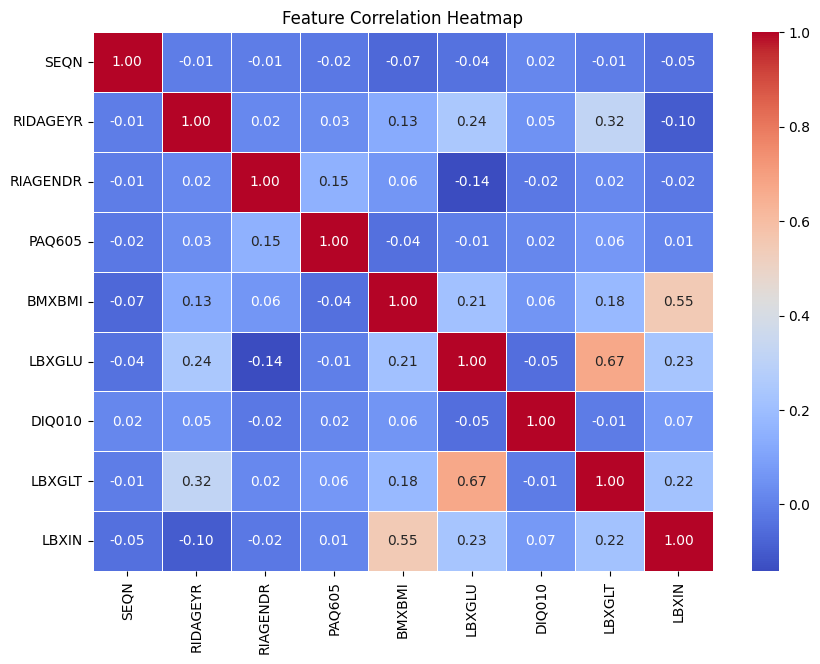

In [43]:
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

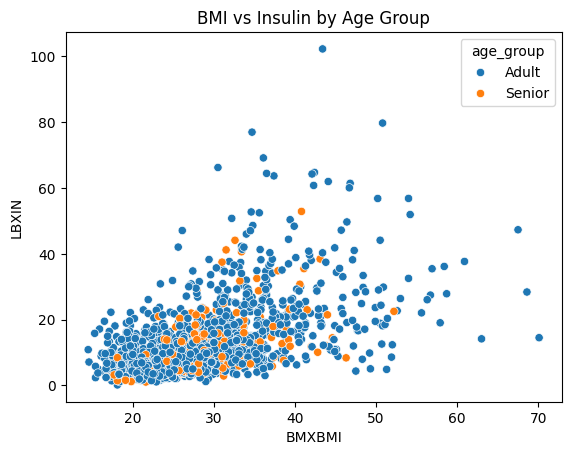

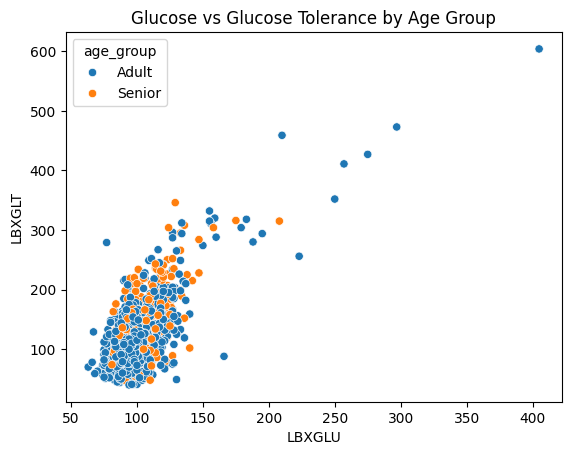

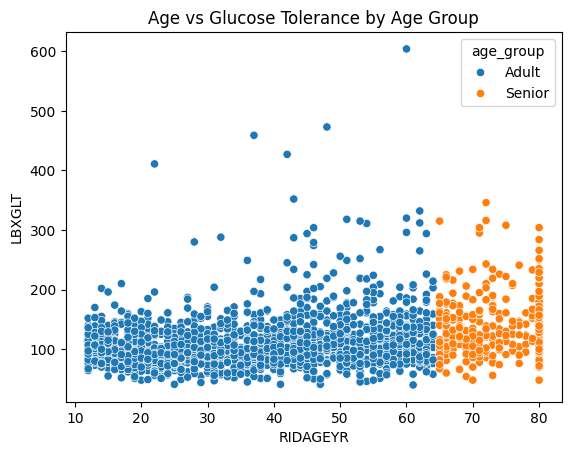

In [44]:
# Plot 1: BMI vs Insulin
sns.scatterplot(data=df, x='BMXBMI', y='LBXIN', hue='age_group')
plt.title('BMI vs Insulin by Age Group')
plt.show()

# Plot 2: Glucose vs Glucose Tolerance
sns.scatterplot(data=df, x='LBXGLU', y='LBXGLT', hue='age_group')
plt.title('Glucose vs Glucose Tolerance by Age Group')
plt.show()

# Plot 3: Age vs Glucose Tolerance
sns.scatterplot(data=df, x='RIDAGEYR', y='LBXGLT', hue='age_group')
plt.title('Age vs Glucose Tolerance by Age Group')
plt.show()

In [51]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

X = df.drop(['age_group','SEQN'], axis=1)
y = df['age_group']

y_encoded = le.fit_transform(y)

In [52]:
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [53]:
imputer = SimpleImputer(strategy="median")

X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [54]:
param_dist = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.5, 1, 2]
}

In [55]:
model = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    verbosity=0
)

# Stratified K-Fold for classification
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,  # number of parameter settings to sample
    scoring='accuracy',
    cv=cv,
    verbose=1,
    n_jobs=-1  # use all cores
)

# Fit RandomizedSearchCV
random_search.fit(X_imputed, y_encoded)

# Print best parameters and accuracy
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.7, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.5}
Best CV Accuracy: 0.9923702871313985


In [56]:
# Final model with best hyperparameters
final_model = XGBClassifier(
    subsample=0.7,
    reg_lambda=0.5,
    reg_alpha=0.1,
    n_estimators=100,
    max_depth=7,
    learning_rate=0.2,
    gamma=0,
    colsample_bytree=0.5,
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    verbosity=0
)

# Fit on full training data
final_model.fit(X_imputed, y_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [57]:
# Load test data
test_data = pd.read_csv('Test_Data.csv')
test_ids = test_data['SEQN']

# Impute test data using the same imputer
X_test = test_data[X.columns]  # Ensure same columns as training
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

In [58]:
# Predict class labels
test_preds = final_model.predict(X_test_imputed)

# Convert back to original category labels
test_preds_labels = le.inverse_transform(test_preds)

# Create submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'age_group': test_preds_labels
})

submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created.")

Submission file 'submission.csv' created.


In [59]:
subm = pd.read_csv('submission.csv')
subm['age_group'].value_counts()

,count
age_group,
Adult,266
Senior,46
